Imports

In [1]:
!python --version
import matplotlib
import matplotlib.pyplot
import pandas as pd
import torch
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy


import torchvision as torchvision
#from PIL import Image

Python 3.10.8


Functions defined

In [93]:
import sys


def load_dataset():
    paths = []
    testpaths = []
    testlabels = []
    terminator = 'D:/Uni/19.Master/Daten/terminator.wav'
    print(sys.executable)
    labels = []
    # for dirname, _, filenames in os.walk('Daten/TESS Toronto emotional speech set data'):
    # D:\Uni\19.Master\DATEN
    for dirname, _, filenames in os.walk('../tess'):
        for filename in filenames:
            label = filename.split('_')[-1]
            label = label.split('.')[0]
            if (label != 'neutral'):
                labels.append(label.lower())
                paths.append(os.path.join(dirname, filename))
    for dirname, _, filenames in os.walk('../stimuli_intensitätsmorphs'):
        for filename in filenames:

            intens = filename.split('_')[-2]
            emot = filename.split('_')[1]
            label = emot
            match label:
                case 'ang':
                    label = 'angry'
                case 'dis':
                    label = 'disgust'
                case 'fea':
                    label = 'fear'
                case 'hap':
                    label = 'happy'
                case 'sad':
                    label = 'sad'
                case 'sur':
                    label = 'ps'
            if (emot != 'ple'):
                testpaths.append(os.path.join(dirname, filename))
                testlabels.append(label.lower())
    com_labels = testlabels + labels
    com_paths = testpaths + paths
    print(testlabels)
    print(testpaths)
    print('Dataset is loaded')
    return paths, labels, testpaths, testlabels

def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def spectrogram_image(y, sr, out, hop_length, n_mels):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
    mels = numpy.log(mels + 1e-9) # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(numpy.uint8)
    img = numpy.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy

    # save as PNG
    #plt.axis('off')
    plt.imsave("spec.png",img)
    plt.imshow(img)

def createSpectrogramm(path, label):
    data, sr = librosa.load(path)
    fourier = librosa.stft(data)
    fourierdb = librosa.amplitude_to_db(abs(fourier))
    librosa.display.specshow(fourierdb, sr=sr, x_axis='time', y_axis='hz')

def createMelSpectrogramm(path, label):
    data, sr = librosa.load(path, sr=22050, offset=0, duration=1)
    melSpec = librosa.feature.melspectrogram(data, sr, n_mels=192, n_fft=1024, hop_length=260)

    # plt.figure(figsize=(10, 4))
    # plt.title(label, size=20)
    librosa.display.specshow(melSpec, sr=sr, x_axis='time', y_axis='hz')
    # plt.colorbar()


In [12]:
trainpaths, trainlabels, testpaths, testlabels = load_dataset()

###create dataframes for training and testing###
trainDF = pd.DataFrame()
trainDF["speech"] = trainpaths
trainDF["label"] = trainlabels
testDF = pd.DataFrame()
testDF["speech"] = testpaths
testDF["label"] = testlabels

testDF

C:\Users\Toni\ProgrammingProjects\masterarbeit_programming\venv\Scripts\python.exe
['angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'disgust', 'disgust', 'disgust', 'disgust', 'disgust', 'disgust', 'disgust', 'disgust', 'disgust', 'disgust', 'disgust', 'disgust', 'disgust', 'disgust', 'disgust', 'disgust', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'ps', 'ps', 'ps', 'ps', 'ps', 'ps', 'ps', 'ps', 'ps', 'ps', 'ps', 'ps', 'ps', 'ps', 'ps', 'ps', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry',

,speech,label
0,../stimuli_intensitätsmorphs\nf01_ang_w01_o_10...,angry
1,../stimuli_intensitätsmorphs\nf01_ang_w01_o_25...,angry
2,../stimuli_intensitätsmorphs\nf01_ang_w01_o_50...,angry
3,../stimuli_intensitätsmorphs\nf01_ang_w01_o_75...,angry
4,../stimuli_intensitätsmorphs\nf01_ang_w02_o_10...,angry
...,...,...
763,../stimuli_intensitätsmorphs\nm04_sur_w03_o_75...,ps
764,../stimuli_intensitätsmorphs\nm04_sur_w05_o_10...,ps
765,../stimuli_intensitätsmorphs\nm04_sur_w05_o_25...,ps
766,../stimuli_intensitätsmorphs\nm04_sur_w05_o_50...,ps


C:\Users\Toni\ProgrammingProjects\masterarbeit_programming\venv\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


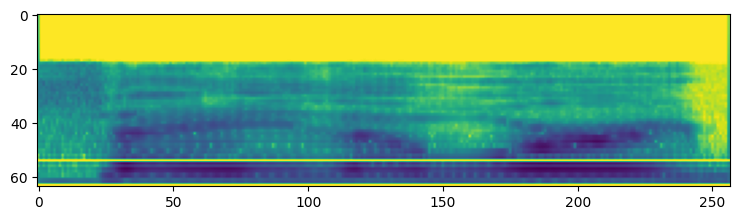

In [100]:
path = trainDF["speech"][0]
# settings
hop_length = 302 # number of samples per time-step in spectrogram
n_mels = 64 # number of bins in spectrogram. Height of image
time_steps = 256 # number of time-steps. Width of image

# load audio. Using example from librosa
y, sr = librosa.load(path, offset=0.1, duration=1, sr=99100)
out = 'out.png'

# extract a fixed length window
start_sample = 0 # starting at beginning
length_samples = time_steps*hop_length
window = y[start_sample:start_sample+length_samples]

# convert to PNG
spectrogram_image(window, sr=sr, out=out, hop_length=hop_length, n_mels=n_mels)

#train_spectros = trainDF["speech"].apply(lambda x: spectrogram_image(x))

In [101]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()


Using cache found in C:\Users\Toni/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\Toni\ProgrammingProjects\masterarbeit_programming\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Toni\ProgrammingProjects\masterarbeit_programming\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

AttributeError: 'AlexNet' object has no attribute 'summary'